In [1]:
# 한국어 토크나이저 다운로드를 위한 코드
!pip install -U pip
!pip install -q konlpy

# 군집화를 위한 sentence-transformer 를 위해 다운로드 
!pip install -U sentence-transformers
# 한국어 토크나이저중 mecab 사용을 위해 다운로드 
!pip install -q python-mecab-ko

# sparse-topn을 사용하기 위한 코드임 
!pip install -q /kaggle/input/sparse-dot-topn-033/sparse_dot_topn-0.3.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.0 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.8 MB/s eta 0:00:00


In [3]:
# Pretrained Tokenizer mecab 은 세팅 
from mecab import MeCab

mecab = MeCab()

def tokenizer_mecab(text):
    return mecab.morphs(text)

In [7]:
import random
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

korean_essay = pd.read_csv('/kaggle/input/korean-essay/korean_essay.csv')[:501]
real_test_df = pd.read_csv('/kaggle/input/llm-detection-result/gpt3.5-1.csv')
display(real_test_df.head())
display(korean_essay.head())
print('실제 논술 데이터 : ',len(real_test_df))
print('korean essay : ', len(korean_essay))

/tmp/ipykernel_33/2958402213.py:6: DtypeWarning: Columns (0,1,2,3,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  korean_essay = pd.read_csv('/kaggle/input/korean-essay/korean_essay.csv')[:501]


,id,Model,percent,AI Response
0,1.0,GPT-3.5,0,73
1,2.0,GPT-3.5,0,77
2,3.0,GPT-3.5,0,85
3,4.0,GPT-3.5,0,87
4,5.0,GPT-3.5,0,85


,ID,model,대학,제시문,중간,문제,공백,생성 Text,비고
0,NaN,GPT-3.5,2012학년도 연세대학교 논술(사회계열) 입학시험 문제,제시문 (가)\n새로운 종교를 창설하려는 여러 번의 시도가 실패로 끝난 것은 상당히...,\n,한 사회에 새로움이 부상하는 과정에서 다수가 수행하는 역할을 중심으로 제시문 (가)...,,\n제시문 (가)는 역사적으로 새로운 종교를 창설하려는 시도가 실패로 끝났음에도 불...,NaN
1,NaN,GPT-3.5,2013학년도 연세대학교 논술(사회계열) 입학시험 문제,(가)\n가-1. \n기원전 4세기경 그리스 철학자 데모스테네스는 “자기를 속이는 ...,\n,"제시문 (가-2)를 바탕으로 제시문 (나)와 (다)를 비교 분석하시오. (1,000...",,제시문 가-2에서는 돈 키호테와 산초의 대화를 통해 현실과 환상 사이의 갈등이 나타...,NaN
2,NaN,GPT-3.5,2013학년도 연세대학교 논술(인문계열) 입학시험 문제,"제시문 (가)\n강녕의 용반, 소주의 등위, 항주의 서계는 모두 매화 산지이다.\n...",\n,"제시문 (가), (나), (다)에 공통된 주제어를 찾고, 이를 바탕으로 제시문 (가...",,"주제어로 선택된 공통 키워드는 ""아름다움""입니다.\n\n제시문 (가)에서는 매화의 ...",NaN
3,NaN,GPT-3.5,2014학년도 연세대학교 수시모집 논술 (사회계열) 입학시험 문제지,제시문 (가)\n개인에 있어서의 합리적인 선택 원칙을 사회 전체에 적용할 수 있으려...,\n,개인과 사회는 서로 영향을 미칠 수 있다. 개인이 사회에 영향을 미치는 정도가 높은...,,네 제시문들의 순서를 정하기 위해서는 각 제시문이 개인과 사회 간 영향을 어떻게 다...,NaN
4,NaN,GPT-3.5,2014학년도 연세대학교 수시모집 논술 (사회계열) 입학시험 문제지,제시문 (가)\n개인에 있어서의 합리적인 선택 원칙을 사회 전체에 적용할 수 있으려...,\n,현대 사회에서는 구성원 상호간에 서로 상충된 요구와 주장들이 늘어나고 있다. 이와 ...,,네 제시문들에는 현대 사회에서의 갈등 상황에 대한 다양한 해법과 접근 방식이 내포되...,NaN


실제 논술 데이터 :  501
korean essay :  501


In [8]:
real_test_df['생성 Text'] = korean_essay['생성 Text']
real_test_df['generated'] = real_test_df['AI Response'].apply(lambda x: x/100)
real_test_df['label'] = real_test_df['Model'].apply(lambda x: 1 if 'gpt' in str(x).lower() else 0)

In [10]:
real_test_df = real_test_df[['생성 Text','label','generated']]
real_test_df.sample(10)                        

,생성 Text,label,generated
226,양립론자의 입장에서 제시문 <다>의 실험 결과는 자유의지의 존재를 부정하는 증거가 ...,0,0.85
491,제시문 에서 놀부의 결정은 경제적 효율성과 자립을 중시하는 입장에서 일정 부분 타당...,1,0.85
495,제시문에서 '표현의 자유'는 인간의 이성을 기반으로 한 자유롭고 공개된 의견 교환을...,1,0.82
245,\n제시문 <나>에서는 글쓰기와 문자의 사용이 인간의 내면적 잠재력을 실현하고 의식...,1,0.75
164,제시문 [가]∼[바]는 사회과학(사회·문화 현상)의 연구방법론에 대한 두 가지 접...,0,0.85
152,"제시문 [라], [마], [바], [사]는 자유주의적 정의관을 옹호하는 [라]와 [...",0,0.75
33,(가)와 (나)에서는 문화의 형성 원리와 성격에 대해 다양한 측면을 다룹니다. (가...,1,0.75
418,"는 것이 필연적임을 말한다. 이는 인간이 자연의 일부이며, 그 안에서만 진정한 의미...",1,0.73
22,(가)에서는 무지함과 앎의 관점을 탐구하고 있습니다. 무지한 자는 자신이 무지한 것...,1,0.73
443,"제시문 (라)와 (마)의 논지를 종합적으로 고려할 때, 제시문 (바)에 나타난 ‘모...",1,0.73


In [11]:
real_test_df = real_test_df.rename(columns={'fixed_probability': 'generated'})
real_test_df['generated'] = real_test_df['generated'].apply(lambda x: x/100)
real_test_df.sample(10)

,생성 Text,label,generated
314,제시문 가) 나) 다) 라)는 모두 시인 윤동주를 대상으로 쓴 글이다. 그것들은\n...,0,0.0075
345,제시문 (사)는 세상에는 우리의 의지대로 할 수 있는 일과 그렇지 않은 일이 있으며...,1,0.0073
382,"제시문 (사)의 관점에서 내집단과 외집단의 구분은 집단의 결속력을 강화하고, 집단의...",1,0.0077
491,제시문 에서 놀부의 결정은 경제적 효율성과 자립을 중시하는 입장에서 일정 부분 타당...,1,0.0085
316,"제시문 [가]의 관점에서 보면, 제시문 [나]의 글쓴이가 시를 감상하는 방식은 창조...",1,0.0085
323,(나)와 (다)에서 제시된 정책들의 공통적인 한계는 정책의 지속성과 효과성에 대한 ...,1,0.0073
401,<가>와 <나> 가운데 (자료 1)을 분석하기에 적합한 것은 <가>입니다. (자료 ...,1,0.0070
234,제시문 (가)와 제시문 (나)에서 말하고 있는 올바른 독서에 대한 관점은 서로 상반...,1,0.0070
104,"(가)와 (나)는 사회에서의 규범과 법에 관한 제시문이며, 사회적인 질서와 규율에 ...",1,0.0085
315,제시문 가) 나) 다) 라)는 모두 시인 윤동주를 대상으로 쓴 글이다. 그것들은\n...,0,0.0050


In [12]:
real_test_df = real_test_df[['생성 Text','label','generated']]
real_test_df = real_test_df[:501]
real_test_df.sample(10)

,생성 Text,label,generated
449,"제시문 [A]는 의사소통이 개인의 삶의 질, 건강, 웰빙에 미치는 중요성을 강조하며...",1,0.0085
367,(가)는 늘어나는 지구의 온실가스 농도에 대응하여 기후 변화 협약에 따라 온실 가스...,0,0.0073
80,\n제시문 (1)은 혼종화에 대한 이해와 문화간 상호작용에 관한 논의를 다루고 있습...,1,0.0085
136,[가]~[바]는 행복을 바라보는 관점 중 물질(경제) 중심적 관점과 비물질(비경제)...,0,0.0085
493,「난타」와 「명성황후」는 한국 문화의 세계화를 다루는 두 가지 사례입니다. 「난타」...,1,0.0073
319,백남준의 예술과 르네상스 시기 오페라의 탄생은 예술 융·복합이 성공적으로 이루어진...,1,0.0085
184,"\n[가]에서는 ""편견""이라는 주제를 중심으로 엘리자베스와 다아시의 이야기를 통해...",1,0.0085
21,\n(가)와 (나)를 통해 알 수 있는 농업혁명의 의의는 '성공과 고통을 동시에 불...,0,0.0077
346,(가)~(라)에는 다양한 평가 기준과 그로 인한 결과가 나타나 있다. (가)에는 자...,0,0.0085
266,"\n제시문 (가)에서 대화가 ㉠ ""넌 남의 제사에 가서 곡을 해본 적이 있느냐?""에...",1,0.0073


In [13]:
real_test_df.tail(10)

,생성 Text,label,generated
491,제시문 에서 놀부의 결정은 경제적 효율성과 자립을 중시하는 입장에서 일정 부분 타당...,1,0.0085
492,"제시문은 텔레비전 프로그램의 국제 유통에서 경제적, 정치적, 문화적 요인이 중요한 ...",1,0.0085
493,「난타」와 「명성황후」는 한국 문화의 세계화를 다루는 두 가지 사례입니다. 「난타」...,1,0.0073
494,자유와 평등의 조화가 실현된 자유민주주의 사회를 이루기 위해 제시문에서는 상호간의 ...,1,0.0087
495,제시문에서 '표현의 자유'는 인간의 이성을 기반으로 한 자유롭고 공개된 의견 교환을...,1,0.0082
496,"오이디푸스의 결단은 제시문에서 제시된 개인과 공동체의 관계 관점 중 ③번, 즉 ""개...",1,0.0073
497,[가] 요약: 제시문 [가]에서는 헤라클레이토스와 크리틸루스의 견해를 통해 시간을 ...,1,0.0073
498,"[다] 요약: 제시문 [다]는 ""오늘""에 초점을 맞추고 있으며, 지나간 과거나 오지...",1,0.0077
499,제시문 [마]와 [바] 요약: 제시문 [마]는 정확한 시간 측정의 필요성이 해양 항...,1,0.0077
500,[가]부터 [바]까지 제시된 다양한 시간의 개념과 삶에 대한 태도는 서로 다른 문화...,1,0.0085


In [14]:
import argparse
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sparse_dot_topn import awesome_cossim_topn


class TextMatcher:
    def __init__(self, ground_truth, col, topk=5, lower_bound=-1):
        self.ground_truth = ground_truth
        self.vec = TfidfVectorizer(ngram_range=(1, 2), analyzer="word",tokenizer=tokenizer_mecab,
                                   use_idf=False, min_df=2, binary=True)
        self.topk = topk
        self.lower_bound = lower_bound
        self.col = col
        
    def get_matches_df(self, sparse_matrix, texts):
        non_zeros = sparse_matrix.nonzero()

        text_indices = non_zeros[0]
        gt_indices = non_zeros[1]

        left_side = np.empty(gt_indices.size, dtype=object)
        right_side = np.empty(gt_indices.size, dtype=object)
        match_score = np.zeros(gt_indices.size)

        for index in range(gt_indices.size):
            left_side[index] = texts.values[text_indices[index]]
            right_side[index] = self.ground_truth[self.col].values[gt_indices[index]]
            match_score[index] = sparse_matrix.data[index]

        res_df = pd.DataFrame({self.col: left_side,
                               'Ground Truth': right_side,
                               'match_score': match_score})

        res_df = pd.DataFrame(texts).merge(res_df, on=self.col, how="left")
        return res_df


    def match(self, texts_to_match, n_threads=16):
        print(f"Matching {texts_to_match.shape[0]} texts to {self.ground_truth.shape[0]} texts...")
        
        X = self.vec.fit_transform(texts_to_match[self.col])
        X_gt = self.vec.transform(self.ground_truth[self.col])
        
        sparse_sim = awesome_cossim_topn(X, X_gt.T, self.topk, self.lower_bound, use_threads=True, n_jobs=n_threads)
        
        return self.get_matches_df(sparse_sim, texts_to_match[self.col])

In [15]:
#---------------------------------------------------------------------------------------------------------#

# E: Ahmet's Approach
# !python run_ahmet_approach.py \
# --score_path ./outputs/m0.parquet \
# --save_dir "./outputs" \
# --model_id "m5"

#---------------------------------------------------------------------------------------------------------#

# 우리가 볼 df -> test_df
df = real_test_df.copy()
df['prompt_id'] = 0
df['id'] = [ i for i in range(len(df))]
all_prompts = df["prompt_id"].unique()
df = df.rename(columns={'생성 Text': 'text'})
 
# HUMAN_TH = 0.1
# LLM_TH = 0.99

HUMAN_TH = 0.2
LLM_TH = 0.8

MIN_N = min(64, len(df))

df_list = []

for pid in all_prompts:
    
    # prompt id 현재 pid 인 값만 가져오기
    cdf = df[df['prompt_id']==pid].copy() 
    
    # 위에서부터 generated 값 낮은것부터 정렬해서 가져옴
    cdf = cdf.sort_values(by='generated').reset_index(drop=True)
    
    # 0.1 보다 낮거나 같으면 인간이 생성한거임 
    cdf["likely_student"] = cdf["generated"].apply(lambda x: x<=HUMAN_TH)
    
    # 0.99보다 같거나 크면 llm 이 생성한 거임 
    cdf["likely_llm"] = cdf["generated"].apply(lambda x: x>=LLM_TH)
    
    # likely_student 의 전체합이 Min_N 보다 작으면 MIN_N 행까지 likely_Student 값을 True 로 만든다.
    if cdf["likely_student"].sum() < MIN_N:
        cdf.loc[:MIN_N, "likely_student"] = True
    
    # likely llm 전체 합 값이 MIN_M보다 작으면 뒤에서부터 MIN_N까지의 likley llm 값을 True로 만든다. 
    if cdf["likely_llm"].sum() < MIN_N:
        cdf.loc[cdf.shape[0] - MIN_N:, "likely_llm"] = True
        
    display(cdf.head())
    display(cdf.tail())
    print("=="*40)
    df_list.append(cdf)

# 다합치고 generated 확률값없애는 거임 
df = pd.concat(df_list).reset_index(drop=True)
df = df.drop(columns=['generated'])

,text,label,generated,prompt_id,id,likely_student,likely_llm
0,997년 복제 양 돌리의 탄생은 인류에게 큰 충격과 동시에 깊은 성찰의 기회를 제공...,1,0.0023,0,275,True,False
1,\n가)의 이름 부르기와 나)의 정치적 올바름의 공통점은 바로 다)의 ᄀ을 모두 전...,0,0.0043,0,17,True,False
2,"■ <제시문 A>, <제시문 B> 활용 <자료 3> 분석\n<자료 3>은 우리나라 ...",0,0.0043,0,399,True,False
3,"가문은 자연을 바라보며 당면한 고요한 순간을 묘사하고, 지루함과 무미건조함을 느낍...",1,0.0047,0,166,True,False
4,\n황석영의 소설 「삼포 가는 길」과 현기영의 소설 『지상에 숟가락 하나』에서 나타...,1,0.0048,0,396,True,False


,text,label,generated,prompt_id,id,likely_student,likely_llm
496,제시문 4는 생물 언어적 다양성의 중요성과 언어 소멸의 심각성을 강조하고 있다. 생...,1,0.0087,0,306,True,True
497,한 나라가 성공적인 국가로 나아가기 위해서는 교육이 핵심이다. 교육은 인재를 양성하...,1,0.0095,0,381,True,True
498,"다모가 범한 죄인 '술 담근 죄'는 사회적, 도덕적으로 매우 심각한 문제를 초래할 ...",1,0.0095,0,356,True,True
499,성적 기준의 방식을 선택하겠다. 장학금 지급을 학생들에 대한 투자로 볼 때 이 방식...,0,0.0095,0,404,True,True
500,(2) ( ) ‘ ’ . 제시문 마 의 붉은 여왕의 나라 는 두 가지 의미를 가지고...,0,0.0095,0,286,True,True


In [16]:
#---------------------------------------------------------------------------------------------------------#
# MATCHING
#---------------------------------------------------------------------------------------------------------#

# 최소 64 개의 코사인 유사도를 구할거임 
TOPK = min(64, len(df))


# 인자로 score 배열 가져옴
def agg_fn(scores, margin=0.5):
    
    # 스코어 배열중 최대값 가져옴
    max_score = max(scores)
    
    #  margin 이 0.5 일시 최대값의 절반값이 된다. -> 이를 기준치라고 하자
    th = (1.0 - margin) * max_score
    
    # 기준치보다 큰수만 남긴다 이를 kept_scores 라고 한다. 
    kept_scores = [s for s in scores if s >= th]
    
    # 남겨진 수들의 평균값을 ret 라고 한다. 
    ret = np.mean(kept_scores)
    return ret

def get_match_score(df, gt_filter_col):
    # df[df[gt_filter_col]] 랑 df 는 명백히 다른거임 
    # df 는 전체데이터 즉, prompt_id 기준으로 걸러진거고 
    # df[df[gt_filter_col]] 은 llm,student 들이 잘 해결한거임 
    tm = TextMatcher(df[df[gt_filter_col]].reset_index(drop=True), "text", topk=TOPK)
    
    res_df = tm.match(df, n_threads=4)
    
    # match_score 에서 살짝 변형 시켜주고 text 기준으로 옆으로 이어붙임 
    df = res_df.groupby("text")["match_score"].agg(agg_fn).reset_index().merge(df, on="text")
    return df


sub_dfs = [get_match_score(df[df["prompt_id"] == pid], "likely_student").reset_index(drop=True)[["id", "match_score"]]
           for pid in all_prompts] # TODO: may cause exception?
sub_df = pd.concat(sub_dfs).rename(columns={"match_score": "match_score_student"})


sub_dfs = [get_match_score(df[df["prompt_id"] == pid], "likely_llm").reset_index(drop=True)[["id", "match_score"]]
           for pid in all_prompts]
sub_df2 = pd.concat(sub_dfs).rename(columns={"match_score": "match_score_llm"})

sub_df = sub_df.merge(sub_df2, on="id")

SMOOTH = 0.15

sub_df["new generated"] = -sub_df["match_score_student"] / (sub_df["match_score_llm"] + SMOOTH)
sub_df.head()
# sub_df = sub_df[["id", "generated"]].copy()

# sub_df.to_excel('output_1.xlsx',index=False)

Matching 501 texts to 501 texts...


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Matching 501 texts to 64 texts...


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,id,match_score_student,match_score_llm,new generated
0,6,1.0,0.225070,-2.666167
1,11,1.0,0.173581,-3.090415
2,28,1.0,0.182872,-3.004156
3,16,1.0,0.189605,-2.944601
4,21,1.0,0.177975,-3.049012


In [17]:
display(sub_df.head())
display(real_test_df.head())

,id,match_score_student,match_score_llm,new generated
0,6,1.0,0.225070,-2.666167
1,11,1.0,0.173581,-3.090415
2,28,1.0,0.182872,-3.004156
3,16,1.0,0.189605,-2.944601
4,21,1.0,0.177975,-3.049012


,생성 Text,label,generated
0,\n제시문 (가)는 역사적으로 새로운 종교를 창설하려는 시도가 실패로 끝났음에도 불...,1,0.0073
1,제시문 가-2에서는 돈 키호테와 산초의 대화를 통해 현실과 환상 사이의 갈등이 나타...,1,0.0077
2,"주제어로 선택된 공통 키워드는 ""아름다움""입니다.\n\n제시문 (가)에서는 매화의 ...",1,0.0085
3,네 제시문들의 순서를 정하기 위해서는 각 제시문이 개인과 사회 간 영향을 어떻게 다...,1,0.0087
4,네 제시문들에는 현대 사회에서의 갈등 상황에 대한 다양한 해법과 접근 방식이 내포되...,1,0.0085


In [18]:
# 예시: id 열을 기준으로 두 데이터프레임을 결합합니다.
merged_df = pd.merge(sub_df, df, on="id", how="inner")
display(merged_df.head(20))

,id,match_score_student,match_score_llm,new generated,text,label,prompt_id,likely_student,likely_llm
0,6,1.0,0.225070,-2.666167,"\n""공감""은 다른 이의 감정, 상황, 경험을 이해하고 공유하는 것을 의미합니다. ...",1,0,True,False
1,11,1.0,0.173581,-3.090415,"\n(가) 제시문은 생명 복제 기술의 문제점에 대하여 논하고 있다. 인간의 고유성,...",0,0,True,False
2,28,1.0,0.182872,-3.004156,\n(가)를 통해 '돈'은 물물교환에 있어 상품의 가치를 반영하는 매개 수단임을 알...,0,0,True,False
3,16,1.0,0.189605,-2.944601,\n(가)에서 이름을 부르는 행위는 존재에 의미를 부여하는 행위를 가리키고 있다. ...,0,0,True,False
4,21,1.0,0.177975,-3.049012,\n(가)와 (나)를 통해 알 수 있는 농업혁명의 의의는 '성공과 고통을 동시에 불...,0,0,True,False
5,280,1.0,0.205451,-2.813327,"\n(가)와 (나)에서 나타난 문화의 형성 원리와 성격은 개인의 사회적, 경제적 환...",1,0,True,False
6,18,1.0,0.192278,-2.921600,\n(가)의 주장은 경제적 불평등을 해소하기 위해 부의 재분배가 필요하다는 것입니다...,1,0,True,False
7,44,1.0,0.187617,-2.961941,\n(가)의 필자는 인간의 문해력은 생득적인 것이 아닌 후천적 성취라고 주장하며 현...,0,0,True,False
8,35,1.0,0.181745,-3.014362,\n(가)의 필자는 인간의 유아론적 경향을 서술하며 그동안 과학자들이 '감정적 자아...,0,0,True,False
9,102,1.0,0.187674,-2.961439,"\n[가]에서 주제를 나타내는 단어는 ""역할 바꾸기""입니다. 이 단어를 사용하여 [...",1,0,True,False


In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

min_val = min(merged_df['new generated'])
max_val = max(merged_df['new generated'])

# Min-Max 스케일링 함수 정의
def min_max_scaling(x):
    return (x - min_val) / (max_val - min_val)

merged_df['real_generated']= merged_df['new generated'].apply(min_max_scaling)
# 변환된 결과 확인
display(merged_df.head(20))

,id,match_score_student,match_score_llm,new generated,text,label,prompt_id,likely_student,likely_llm,real_generated
0,6,1.0,0.225070,-2.666167,"\n""공감""은 다른 이의 감정, 상황, 경험을 이해하고 공유하는 것을 의미합니다. ...",1,0,True,False,0.296137
1,11,1.0,0.173581,-3.090415,"\n(가) 제시문은 생명 복제 기술의 문제점에 대하여 논하고 있다. 인간의 고유성,...",0,0,True,False,0.147159
2,28,1.0,0.182872,-3.004156,\n(가)를 통해 '돈'은 물물교환에 있어 상품의 가치를 반영하는 매개 수단임을 알...,0,0,True,False,0.177449
3,16,1.0,0.189605,-2.944601,\n(가)에서 이름을 부르는 행위는 존재에 의미를 부여하는 행위를 가리키고 있다. ...,0,0,True,False,0.198362
4,21,1.0,0.177975,-3.049012,\n(가)와 (나)를 통해 알 수 있는 농업혁명의 의의는 '성공과 고통을 동시에 불...,0,0,True,False,0.161698
5,280,1.0,0.205451,-2.813327,"\n(가)와 (나)에서 나타난 문화의 형성 원리와 성격은 개인의 사회적, 경제적 환...",1,0,True,False,0.244460
6,18,1.0,0.192278,-2.921600,\n(가)의 주장은 경제적 불평등을 해소하기 위해 부의 재분배가 필요하다는 것입니다...,1,0,True,False,0.206439
7,44,1.0,0.187617,-2.961941,\n(가)의 필자는 인간의 문해력은 생득적인 것이 아닌 후천적 성취라고 주장하며 현...,0,0,True,False,0.192273
8,35,1.0,0.181745,-3.014362,\n(가)의 필자는 인간의 유아론적 경향을 서술하며 그동안 과학자들이 '감정적 자아...,0,0,True,False,0.173865
9,102,1.0,0.187674,-2.961439,"\n[가]에서 주제를 나타내는 단어는 ""역할 바꾸기""입니다. 이 단어를 사용하여 [...",1,0,True,False,0.192449


ROC-AUC 면적: 0.6512804232804232


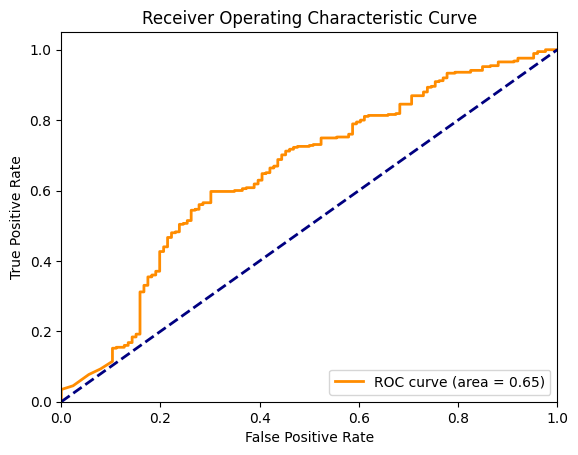

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 실제 라벨
y_true = merged_df['label'].values

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_true, merged_df['real_generated'])
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

# ROC-AUC 면적 출력
print("ROC-AUC 면적:", roc_auc)

plt.show()

In [21]:
from sklearn.metrics import f1_score

# F1 스코어 계산
y_pred = [1 if score > 0.5 else 0 for score in merged_df['real_generated']]  # fixed_results는 모델 예측 결과로 가정
f1 = f1_score(y_true,  y_pred)

# F1 스코어 출력
print("F1 Score:", f1)

F1 Score: 0.24036281179138325
